We consider the following stopping problem. We have a finite series of Bernoulli buttons of length $N$, which means that each button, when we press it, produces with probability $\theta$, $0 \leq \theta \leq 1$ a unit reward and with probability $1-\theta$ no reward at all. The probability $\theta$ itself is a priori unknown and different for each button.
Starting with the first button at each given step we can either press the current button and observe the outcome or move on and press the next one. We are not allowed to return to previous buttons. We consider the case when we have a finite number of button presses (or time steps) $T$. We also introduce a cost for moving to the next button $c$.

We take the Bayessian approach to estimating the probability of a Bernoulli button, namely, our knowledge about Bernoulli buttons success probability $\theta$ is given by a Beta distribution

$$
P(\theta|\alpha, \beta) = \frac{\theta^{\alpha-1} (1-\theta)^{\beta-1}}{B(\alpha,\beta)}.
$$

We suppose that when we move to a new button we start with a prior $\alpha = \alpha_0$, $\beta = \beta_0$.

We model the problem as a Markov Decision Process, thus we search for an optimal policy $\pi(s)$ that maximizes the expected reward

$$
V(s, T, N) = \mathrm{E}\left[\sum_{t = 1}^T r_{a^\pi} (s_t^{\pi}) \right].
$$

Here $s_t$ denotes our knowledge of the button we are pressing at time $t$ (its history of successes and fails)  and $T$ is the total number of button presses we are allowed. This knowledge can be summarized with a pair $(w, f)$, where the values are the number of wins and fails observed so far.
We solve this problem via dynamic programming. The formal solution can be written as

$$
V(s, T, N) = \max_{a\in A}\left(r_a (s) + \sum_{s'\in S} p_a (s, s') V(s', T-1, N')\right),
$$

where $a$ is a particular decision to stay or to move on, $A$ is the space of our actions, $r_a(s)$ is the expected reward for taking an action, $V(s, 0, N) = 0$, $T$ is the number of remaining presses and $N'$ is the number of remaining buttons. Our space of states $S$ consists of our knowledge about the current button we are pressing, so it can be described with a pair $(\alpha, \beta) = (\alpha_0 + w, \beta_0 + f)$ corresponding to a Beta distribution. Our space of actions consists of either pressing the current button and moving to one of the outcomes $(\alpha+1, \beta)$ or $(\alpha, \beta+1)$ with probabilities $\alpha/(\alpha + \beta)$ and $\beta/(\alpha + \beta)$ respectively or moving to the next button, if there is one, and pressing it thus arriving at one of the outcomes $(\alpha_0 + 1, \beta_0)$ or $(\alpha_0, \beta_0+1)$ with probabilities $\alpha_0/(\alpha_0 + \beta_0)$ and $\beta_0/(\alpha_0 + \beta_0)$. By doing so we always have to pay a cost $c$. If there are no button left we have to press the current one the remaining number of times and get an expected reward $V(s, T, 0) = T \alpha/(\alpha + \beta)$. Labeling the expected reward from a button with a prior number of wins and fails $(w, f)$ and the remaining number of steps $T$ and buttons $N$ as $V(w, f, T, N)$ we get the following recurrence relation

$$
V(w, f, T, N) = \max \left\{
\begin{matrix}
\frac{\alpha_0 + w}{\alpha_0 + \beta_0 + w + f} + \frac{\alpha_0 + w}{\alpha_0 + \beta_0 + w + f} V(w+1, f, T-1, N) + \frac{\beta_0 + f}{\alpha_0 + \beta_0 + w + f} V(w, f+1, T-1, N)\\
\frac{\alpha_0}{\alpha_0 + \beta_0} - c + \frac{\alpha_0}{\alpha_0 + \beta_0} V(1, 0, T-1, N-1) + \frac{\beta_0}{\alpha_0 + \beta_0} V(0, 1, T-1, N-1)
\end{matrix}\right.,
$$

and $V(w, f, 0, N) = 0$, $V(w, f, T, 0) = T \alpha/(\alpha + \beta)$.

The optimal policy thus corresponds to comparing

$$
\frac{\alpha_0 + w}{\alpha_0 + \beta_0 + w + f} + \frac{\alpha_0 + w}{\alpha_0 + \beta_0 + w + f} V(w+1, f, T-1, N) + \frac{\beta_0 + f}{\alpha_0 + \beta_0 + w + f} V(w, f+1, T-1, N),
$$ 

to 

$$
\frac{\alpha_0}{\alpha_0 + \beta_0} - c + \frac{\alpha_0}{\alpha_0 + \beta_0} V(1, 0, T-1, N-1) + \frac{\beta_0}{\alpha_0 + \beta_0} V(0, 1, T-1, N-1),
$$

and moving to the next button if the latter is greater. We can evaluate the expected reward expression numerically recursively for any $T$ and $N$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

import os
import sys

import os
if not os.path.exists('Plots'):
    os.mkdir('Plots')

#Loading simulation routines
os.environ['SIMULATION_ROUTINES_PATH'] = os.getcwd() + '/Simulations/'
sys.path.append('Simulations')
import cpp_routines as sim

In [2]:
def coord_plot(table, ax, sz, yend, xst=1, yst=1):
    grid = np.c_[np.repeat(np.arange(1,table.shape[0]+1),table.shape[1]),np.tile(np.arange(1,table.shape[1]+1),table.shape[0])]
    cond = table.reshape((-1))
    ax.set_aspect(1)
    ax.scatter(*grid[cond == 0].T, marker='s', s=sz)
    ax.scatter(*grid[cond == 1].T, marker='s', s=sz)
    if np.any(cond == 2):
        ax.scatter(*grid[cond == 2].T, marker='s', s=sz)
    if xst == 1:
        ax.set_xlim(1,table.shape[0]);
        ax.set_xticks([1]+[5*i for i in range(1,val_finite_trans.shape[0]//5+1)])
    else:
        ax.set_xlim(xst,table.shape[0]);
        ax.set_xticks([5*i for i in range(xst//5,val_finite_trans.shape[0]//5+1)])
    if yst == 1:
        ax.set_ylim(1,yend);
        ax.set_yticks([1]+[5*i for i in range(1,yend//5+1)])
    else:
        ax.set_ylim(yst,yend);
        ax.set_yticks([5*i for i in range(yst//5,yend//5+1)])
    ax.minorticks_on()

# Finite number of buttons policy

In [3]:
val_finite_trans = sim.finite_arm_transition_table(10, 10, 100, 50, prior=(1, 1))

## More successes than failures

The region where the optimal policy prescribes keeping the button is coloured blue, the region where the optimal policy prescribes moving to the next button in coloured orange, the region where staying with the button and quitting the button provides the same reward is coloured green

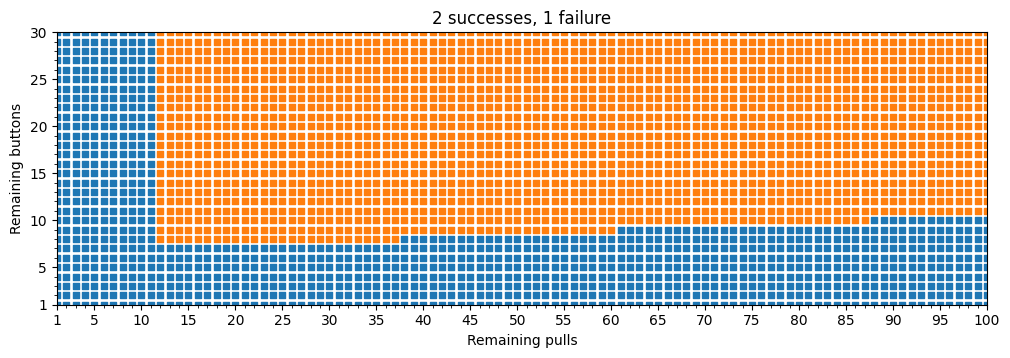

In [4]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
ax.set_title('2 successes, 1 failure')
ax.set_xlabel('Remaining pulls')
ax.set_ylabel('Remaining buttons')
coord_plot(val_finite_trans[:,:,2,1], ax, sz=14, yend=30)

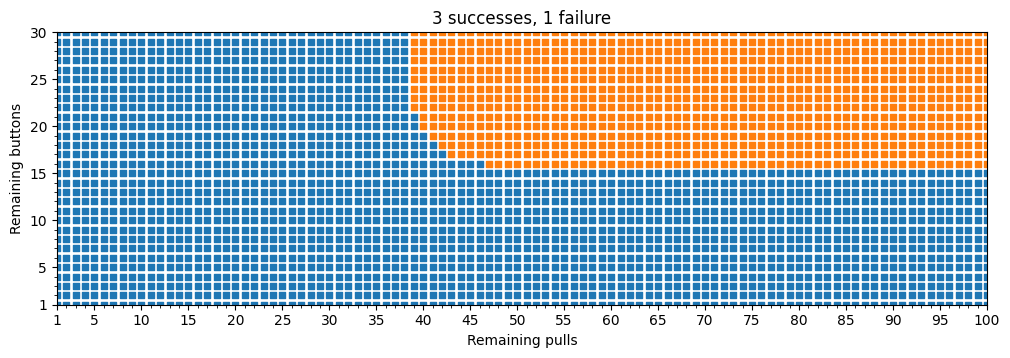

In [5]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
ax.set_title('3 successes, 1 failure')
ax.set_xlabel('Remaining pulls')
ax.set_ylabel('Remaining buttons')
coord_plot(val_finite_trans[:,:,3,1], ax, sz=14, yend=30)

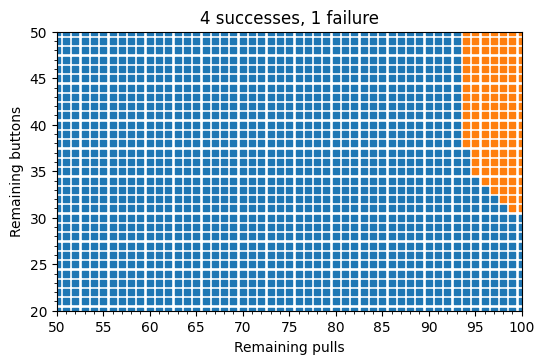

In [6]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
ax.set_title('4 successes, 1 failure')
ax.set_xlabel('Remaining pulls')
ax.set_ylabel('Remaining buttons')
coord_plot(val_finite_trans[:,:,4,1], ax, sz=14, xst=50, yst=20, yend=50)

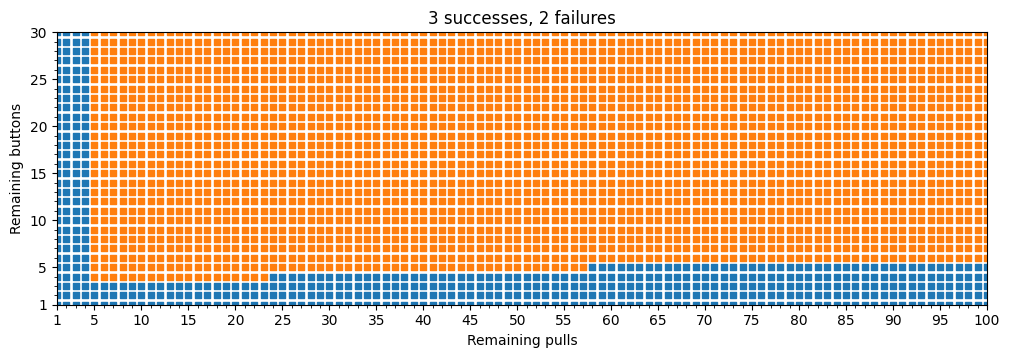

In [7]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
ax.set_title('3 successes, 2 failures')
ax.set_xlabel('Remaining pulls')
ax.set_ylabel('Remaining buttons')
coord_plot(val_finite_trans[:,:,3,2], ax, sz=14, yend=30)

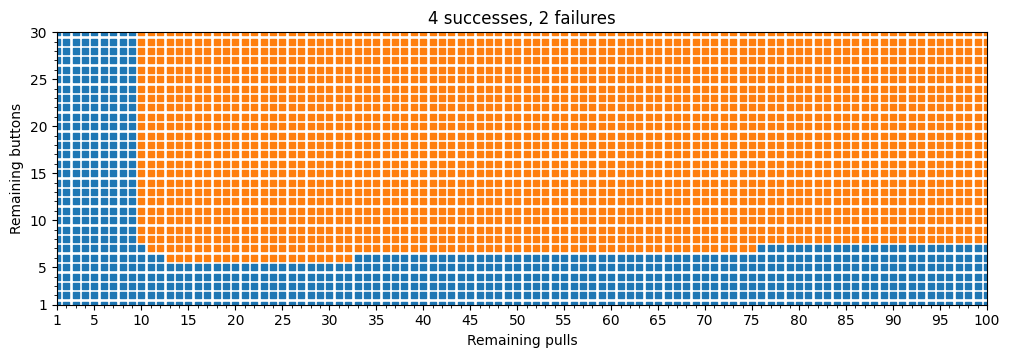

In [8]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
ax.set_title('4 successes, 2 failures')
ax.set_xlabel('Remaining pulls')
ax.set_ylabel('Remaining buttons')
coord_plot(val_finite_trans[:,:,4,2], ax, sz=14, yend=30)

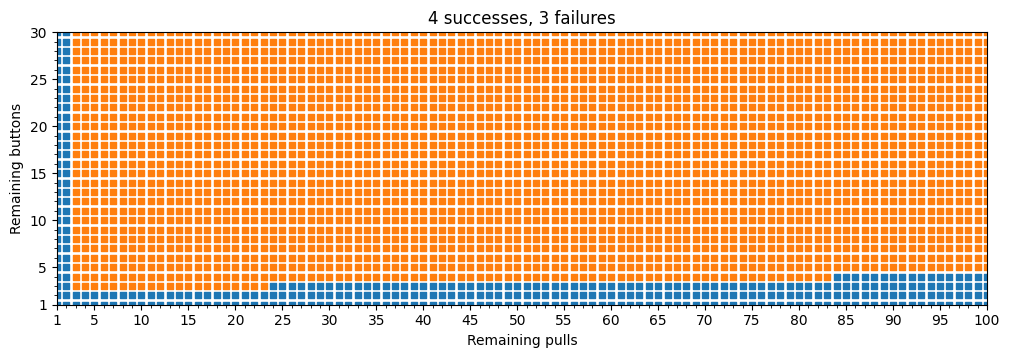

In [9]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
ax.set_title('4 successes, 3 failures')
ax.set_xlabel('Remaining pulls')
ax.set_ylabel('Remaining buttons')
coord_plot(val_finite_trans[:,:,4,3], ax, sz=14, yend=30)

## Equal numbers of successes and failures

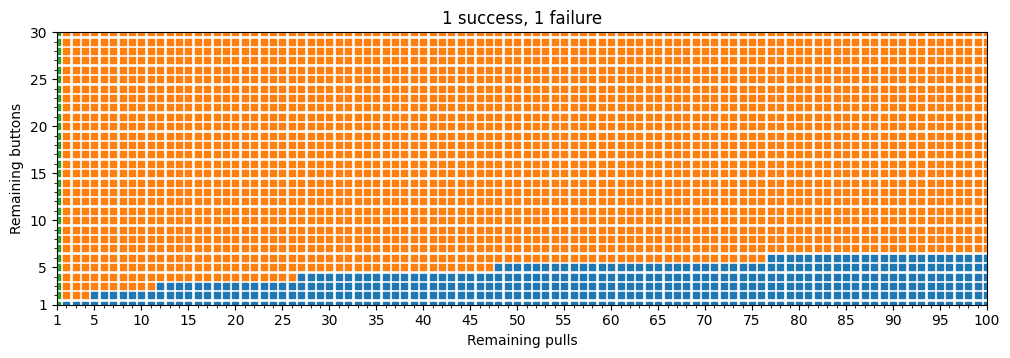

In [10]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
ax.set_title('1 success, 1 failure')
ax.set_xlabel('Remaining pulls')
ax.set_ylabel('Remaining buttons')
coord_plot(val_finite_trans[:,:,1,1], ax, sz=14, yend=30)

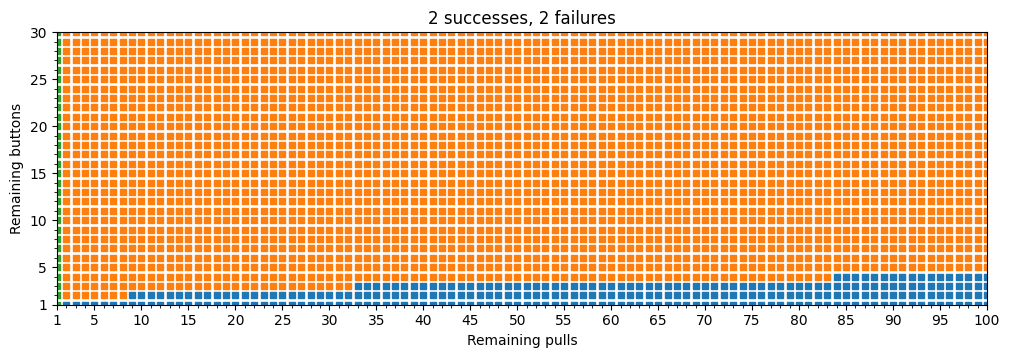

In [11]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
ax.set_title('2 successes, 2 failures')
ax.set_xlabel('Remaining pulls')
ax.set_ylabel('Remaining buttons')
coord_plot(val_finite_trans[:,:,2,2], ax, sz=14, yend=30)

## More failures than successes

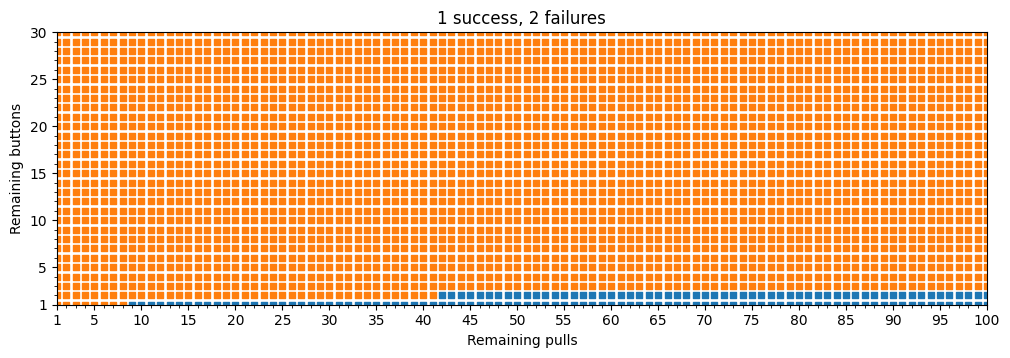

In [12]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
ax.set_title('1 success, 2 failures')
ax.set_xlabel('Remaining pulls')
ax.set_ylabel('Remaining buttons')
coord_plot(val_finite_trans[:,:,1,2], ax, sz=14, yend=30)

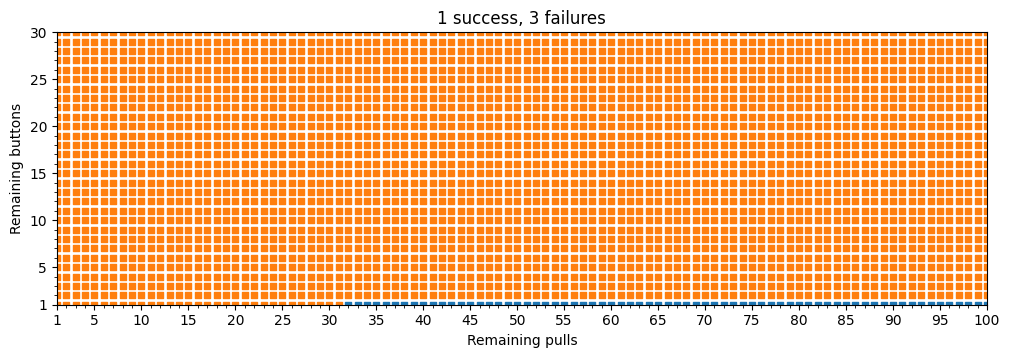

In [13]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
ax.set_title('1 success, 3 failures')
ax.set_xlabel('Remaining pulls')
ax.set_ylabel('Remaining buttons')
coord_plot(val_finite_trans[:,:,1,3], ax, sz=14, yend=30)

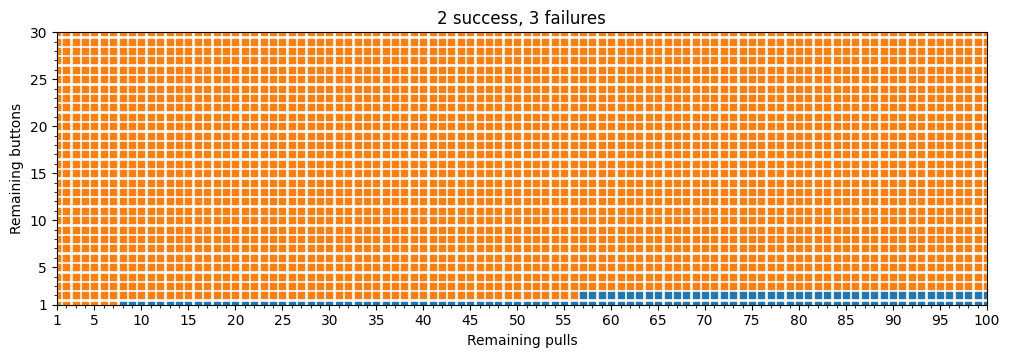

In [14]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
ax.set_title('2 success, 3 failures')
ax.set_xlabel('Remaining pulls')
ax.set_ylabel('Remaining buttons')
coord_plot(val_finite_trans[:,:,2,3], ax, sz=14, yend=30)

## Examining the reward 

Comparing expected reward in case of finite number of buttons to the infinite number of buttons case

In [15]:
val = sim.expected_reward_table(1, 1, 100, prior=(1, 1))
val_finite = sim.finite_arm_expected_reward_table(1, 1, 100, 100, prior=(1, 1))

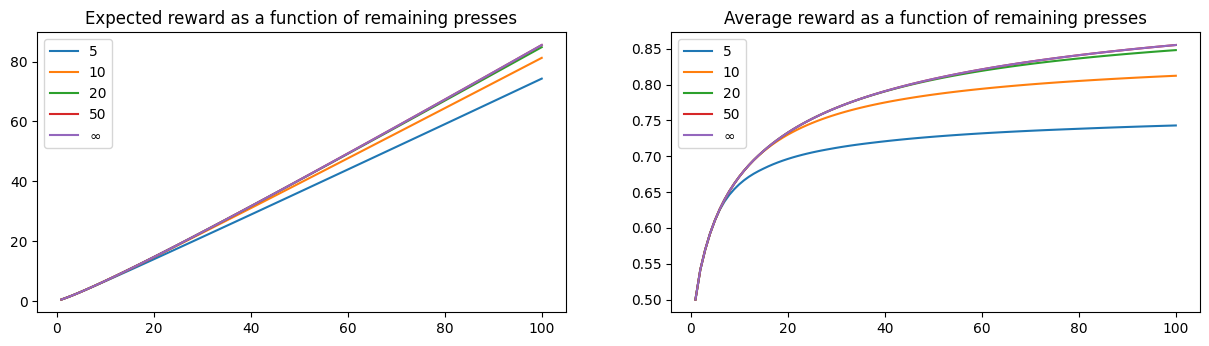

In [16]:
total_buttons_plot = [3, 8, 18, 48]

fig = plt.figure(figsize = (15,8))
ax = fig.add_subplot(221)
ax.set_title("Expected reward as a function of remaining presses")
for i in total_buttons_plot:
    ax.plot(np.arange(1,val_finite.shape[0]+1), val_finite[:,i,0,0], label=str(i+2));
ax.plot(np.arange(1,val.shape[0]+1), val[:,0,0], label='$\infty$')
ax.legend();

ax = fig.add_subplot(222)
ax.set_title("Average reward as a function of remaining presses")
for i in total_buttons_plot:
    ax.plot(np.arange(1,val_finite.shape[0]+1), np.copy(val_finite[:,i,0,0])/np.arange(1,val_finite.shape[0]+1), label=str(i+2));
ax.plot(np.arange(1,val.shape[0]+1), np.copy(val[:,0,0])/np.arange(1,val.shape[0]+1), label='$\infty$')
ax.legend();

# The optimal policy performance simulation

Here we experimentally test the optimal policy we have derived earlier.

The run_bernoulli_trials is run from C++ library.

In [17]:
run_time = 100
number_of_runs = 1000000
number_of_buttons = 10
button_prior = (1, 1)
policy_prior = (1, 1)

button = sim.Button('Bernoulli', prior=button_prior)
policy = sim.Policy('Finite', nbuttons=number_of_buttons, prior=policy_prior)

rewards = sim.run_trials(run_time, number_of_runs, button, policy)

print("The individual run length is: " + str(run_time))
print("The number of runs is: " + str(number_of_runs))
print("The theoretical reward is: " + str(val_finite[run_time-1, number_of_buttons-2, 0, 0]))
print("The theoretical reward for unlimited buttons is: " + str(val[run_time-1, 0, 0]))
print("The mean reward is: " + str(np.mean(rewards)))
print("The deviation is: " + str(np.std(rewards)))
print("The deviation of the mean is: " + str(np.std(rewards)/pow(len(rewards), 0.5)))

The individual run length is: 100
The number of runs is: 1000000
The theoretical reward is: 81.24211108851092
The theoretical reward for unlimited buttons is: 85.53483300174244
The mean reward is: 81.243982
The deviation is: 14.608565185659955
The deviation of the mean is: 0.014608565185659955


Here we inspect aspects of individual instances of the optimal policy we have derived earlier.

The record_full_bernoulli_trials is run from C++ library.

Maximum number of buttons is 5
The average number of buttons explored is 2.9094
Out of 10000 runs in total in 9482 runs (or 94.82%) the last button contributed the most
The average contribution of the button with the largest contribution is 92.03 %


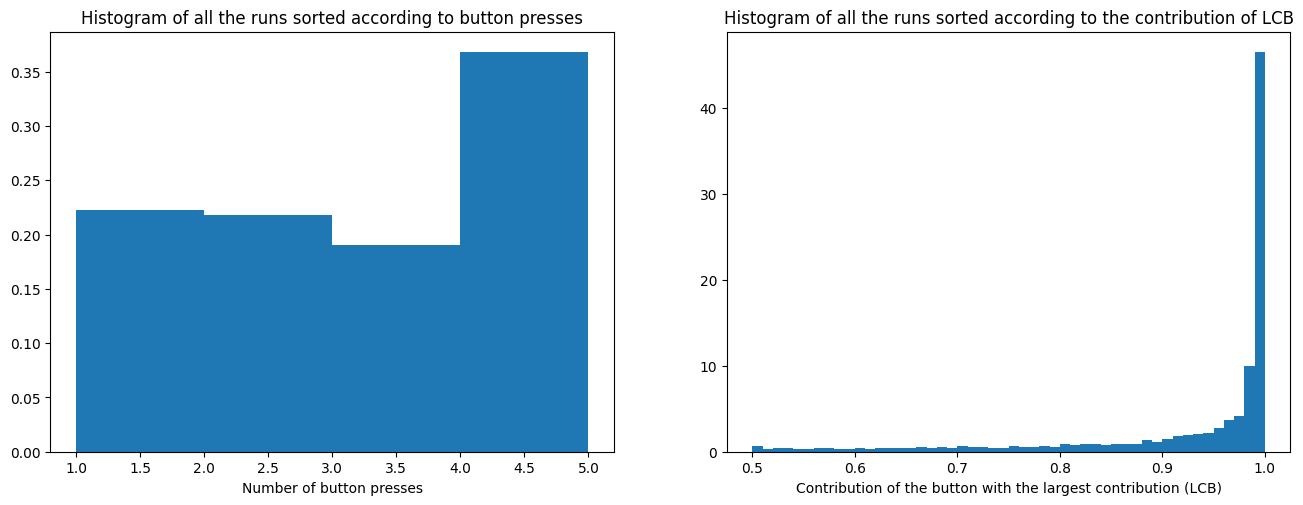

In [18]:
run_time = 100
number_of_runs = 10000
number_of_buttons = 5
button_prior = (1, 1)
policy_prior = (1, 1)

button = sim.Button('Bernoulli', prior=button_prior)
policy = sim.Policy('Finite', nbuttons=number_of_buttons, prior=policy_prior)

trial_record = sim.record_full_trials(run_time, number_of_runs, button, policy)

#Total number of button pressed
num_presses = np.max(trial_record[:,:,0], axis=1)
#Total number of buttons
num_buttons = np.max(trial_record[:,:,0], axis=1)+1
#Index of the button with largest contribution
max_button = trial_record[np.arange(len(trial_record)),
                          np.argmax(trial_record[:,:,1], axis=1),0]
#Number of runs where the final button was the button with the largest contribution
num_last_largest_contr = np.count_nonzero(num_presses==max_button)
#Ratio of largest button contribution to total contribution
tmp = np.sum(trial_record[:,:,3], axis=1)
tmp[tmp == 0] = 1
top_button_to_all = np.max(trial_record[:,:,1], axis=1)/tmp

print("Maximum number of buttons is", number_of_buttons)
print("The average number of buttons explored is " + str(np.sum(num_buttons)/len(num_buttons)))
print("Out of " + str(number_of_runs) + " runs in total in " + str(num_last_largest_contr) + 
            " runs (or " + "%.2f" % (100*num_last_largest_contr/number_of_runs) + 
              "%) the last button contributed the most")
print("The average contribution of the button with the largest contribution is " + 
          "%4.2f" % (100*np.mean(top_button_to_all)) + " %")

fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(221)
ax.set_title("Histogram of all the runs sorted according to button presses")
ax.set_xlabel("Number of button presses")
ax.hist(num_buttons, density=True, bins=number_of_buttons-1, range=(1, number_of_buttons));

ax = fig.add_subplot(222)
ax.set_title("Histogram of all the runs sorted according to the contribution of LCB")
ax.set_xlabel("Contribution of the button with the largest contribution (LCB)")
ax.hist(top_button_to_all, density=True, bins=50, range=(0.5,1));

Maximum number of buttons is 10
The average number of buttons explored is 4.7824
Out of 10000 runs in total in 9586 runs (or 95.86%) the last button contributed the most
The average contribution of the button with the largest contribution is 89.58 %


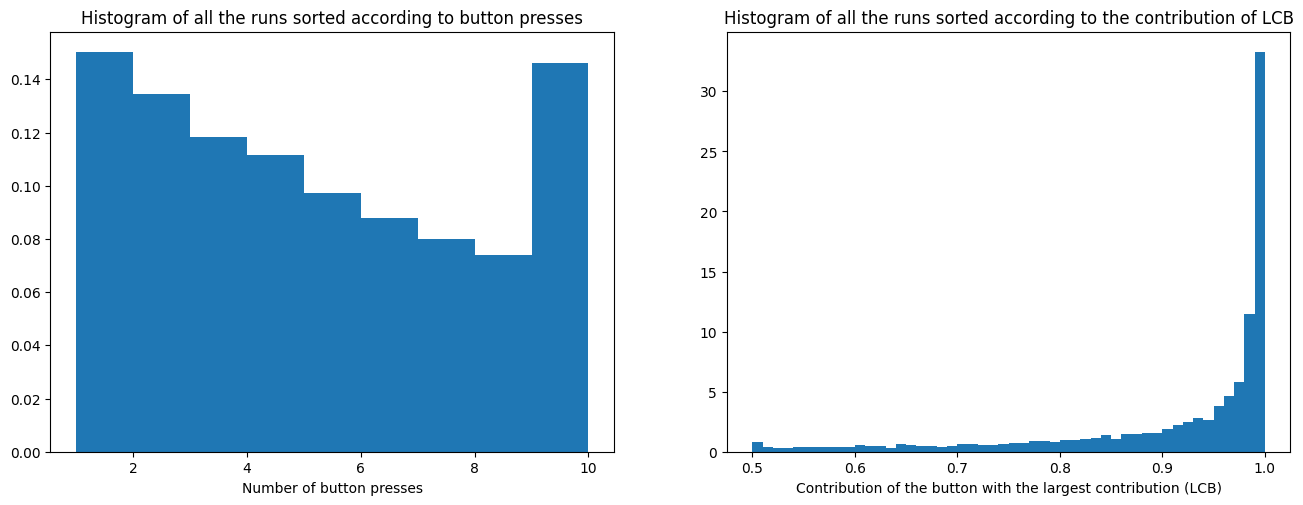

In [19]:
run_time = 100
number_of_runs = 10000
number_of_buttons = 10
button_prior = (1, 1)
policy_prior = (1, 1)

button = sim.Button('Bernoulli', prior=button_prior)
policy = sim.Policy('Finite', nbuttons=number_of_buttons, prior=policy_prior)

trial_record = sim.record_full_trials(run_time, number_of_runs, button, policy)

#Total number of button pressed
num_presses = np.max(trial_record[:,:,0], axis=1)
#Total number of buttons
num_buttons = np.max(trial_record[:,:,0], axis=1)+1
#Index of the button with largest contribution
max_button = trial_record[np.arange(len(trial_record)),
                          np.argmax(trial_record[:,:,1], axis=1),0]
#Number of runs where the final button was the button with the largest contribution
num_last_largest_contr = np.count_nonzero(num_presses==max_button)
#Ratio of largest button contribution to total contribution
tmp = np.sum(trial_record[:,:,3], axis=1)
tmp[tmp == 0] = 1
top_button_to_all = np.max(trial_record[:,:,1], axis=1)/tmp

print("Maximum number of buttons is", number_of_buttons)
print("The average number of buttons explored is " + str(np.sum(num_buttons)/len(num_buttons)))
print("Out of " + str(number_of_runs) + " runs in total in " + str(num_last_largest_contr) + 
            " runs (or " + "%.2f" % (100*num_last_largest_contr/number_of_runs) + 
              "%) the last button contributed the most")
print("The average contribution of the button with the largest contribution is " + 
          "%4.2f" % (100*np.mean(top_button_to_all)) + " %")

fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(221)
ax.set_title("Histogram of all the runs sorted according to button presses")
ax.set_xlabel("Number of button presses")
ax.hist(num_buttons, density=True, bins=number_of_buttons-1, range=(1, number_of_buttons));

ax = fig.add_subplot(222)
ax.set_title("Histogram of all the runs sorted according to the contribution of LCB")
ax.set_xlabel("Contribution of the button with the largest contribution (LCB)")
ax.hist(top_button_to_all, density=True, bins=50, range=(0.5,1));

Maximum number of buttons is 20
The average number of buttons explored is 7.3733
Out of 10000 runs in total in 9701 runs (or 97.01%) the last button contributed the most
The average contribution of the button with the largest contribution is 87.01 %


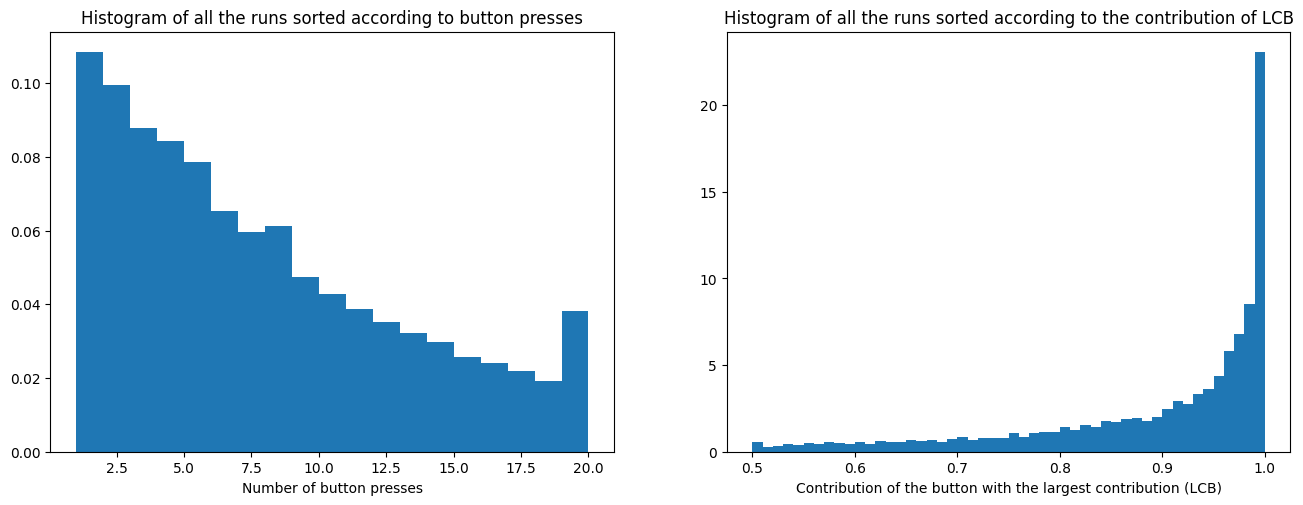

In [20]:
run_time = 100
number_of_runs = 10000
number_of_buttons = 20
button_prior = (1, 1)
policy_prior = (1, 1)

button = sim.Button('Bernoulli', prior=button_prior)
policy = sim.Policy('Finite', nbuttons=number_of_buttons, prior=policy_prior)

trial_record = sim.record_full_trials(run_time, number_of_runs, button, policy)

#Total number of button pressed
num_presses = np.max(trial_record[:,:,0], axis=1)
#Total number of buttons
num_buttons = np.max(trial_record[:,:,0], axis=1)+1
#Index of the button with largest contribution
max_button = trial_record[np.arange(len(trial_record)),
                          np.argmax(trial_record[:,:,1], axis=1),0]
#Number of runs where the final button was the button with the largest contribution
num_last_largest_contr = np.count_nonzero(num_presses==max_button)
#Ratio of largest button contribution to total contribution
tmp = np.sum(trial_record[:,:,3], axis=1)
tmp[tmp == 0] = 1
top_button_to_all = np.max(trial_record[:,:,1], axis=1)/tmp

print("Maximum number of buttons is", number_of_buttons)
print("The average number of buttons explored is " + str(np.sum(num_buttons)/len(num_buttons)))
print("Out of " + str(number_of_runs) + " runs in total in " + str(num_last_largest_contr) + 
            " runs (or " + "%.2f" % (100*num_last_largest_contr/number_of_runs) + 
              "%) the last button contributed the most")
print("The average contribution of the button with the largest contribution is " + 
          "%4.2f" % (100*np.mean(top_button_to_all)) + " %")

fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(221)
ax.set_title("Histogram of all the runs sorted according to button presses")
ax.set_xlabel("Number of button presses")
ax.hist(num_buttons, density=True, bins=number_of_buttons-1, range=(1, number_of_buttons));

ax = fig.add_subplot(222)
ax.set_title("Histogram of all the runs sorted according to the contribution of LCB")
ax.set_xlabel("Contribution of the button with the largest contribution (LCB)")
ax.hist(top_button_to_all, density=True, bins=50, range=(0.5,1));

Maximum number of buttons is 50
The average number of buttons explored is 8.6643
Out of 10000 runs in total in 9795 runs (or 97.95%) the last button contributed the most
The average contribution of the button with the largest contribution is 85.64 %


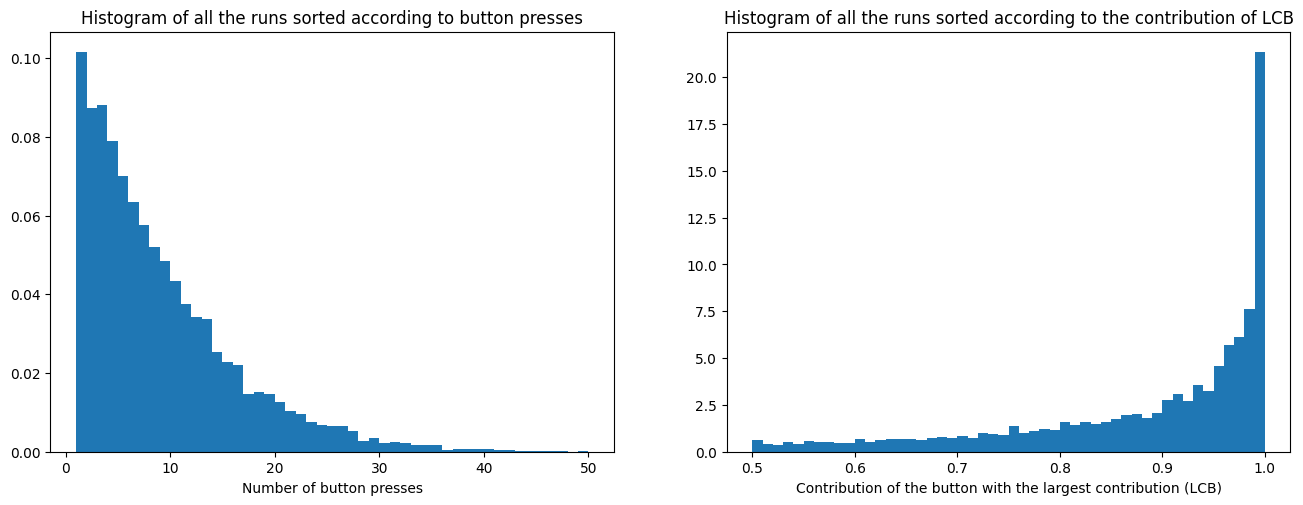

In [21]:
run_time = 100
number_of_runs = 10000
number_of_buttons = 50
button_prior = (1, 1)
policy_prior = (1, 1)

button = sim.Button('Bernoulli', prior=button_prior)
policy = sim.Policy('Finite', nbuttons=number_of_buttons, prior=policy_prior)

trial_record = sim.record_full_trials(run_time, number_of_runs, button, policy)

#Total number of button pressed
num_presses = np.max(trial_record[:,:,0], axis=1)
#Total number of buttons
num_buttons = np.max(trial_record[:,:,0], axis=1)+1
#Index of the button with largest contribution
max_button = trial_record[np.arange(len(trial_record)),
                          np.argmax(trial_record[:,:,1], axis=1),0]
#Number of runs where the final button was the button with the largest contribution
num_last_largest_contr = np.count_nonzero(num_presses==max_button)
#Ratio of largest button contribution to total contribution
tmp = np.sum(trial_record[:,:,3], axis=1)
tmp[tmp == 0] = 1
top_button_to_all = np.max(trial_record[:,:,1], axis=1)/tmp

print("Maximum number of buttons is", number_of_buttons)
print("The average number of buttons explored is " + str(np.sum(num_buttons)/len(num_buttons)))
print("Out of " + str(number_of_runs) + " runs in total in " + str(num_last_largest_contr) + 
            " runs (or " + "%.2f" % (100*num_last_largest_contr/number_of_runs) + 
              "%) the last button contributed the most")
print("The average contribution of the button with the largest contribution is " + 
          "%4.2f" % (100*np.mean(top_button_to_all)) + " %")

fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(221)
ax.set_title("Histogram of all the runs sorted according to button presses")
ax.set_xlabel("Number of button presses")
ax.hist(num_buttons, density=True, bins=number_of_buttons-1, range=(1, number_of_buttons));

ax = fig.add_subplot(222)
ax.set_title("Histogram of all the runs sorted according to the contribution of LCB")
ax.set_xlabel("Contribution of the button with the largest contribution (LCB)")
ax.hist(top_button_to_all, density=True, bins=50, range=(0.5,1));

Unlimited buttons case
The average number of buttons explored is 8.666
Out of 10000 runs in total in 9769 runs (or 97.69%) the last button contributed the most
The average contribution of the button with the largest contribution is 85.62 %


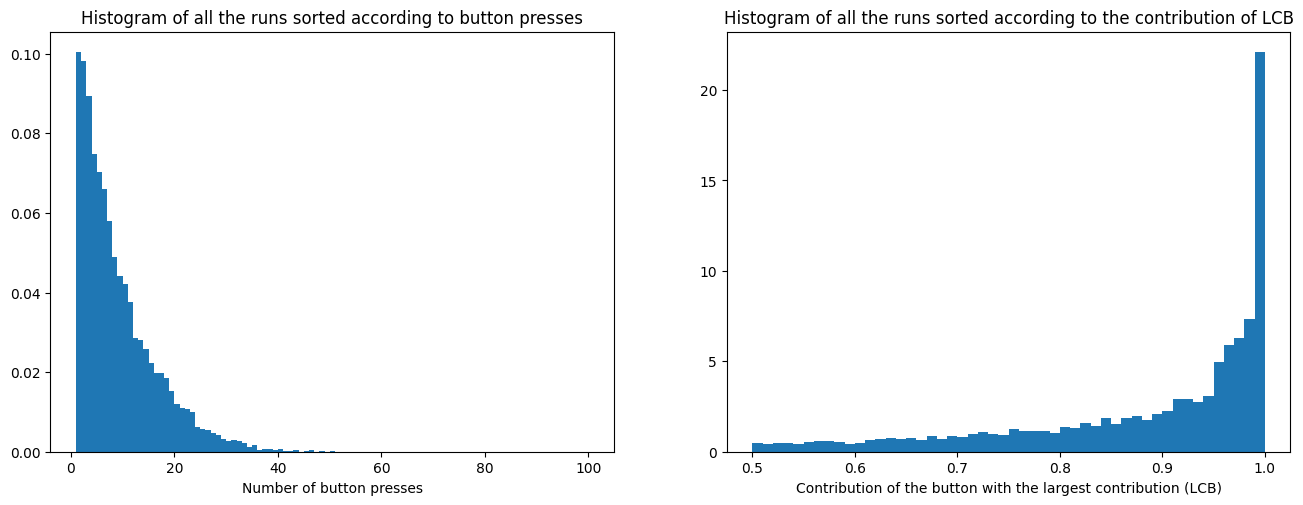

In [22]:
run_time = 100
number_of_runs = 10000
button_prior = (1, 1)
policy_prior = (1, 1)

button = sim.Button('Bernoulli', prior=button_prior)
policy = sim.Policy('Bernoulli', prior=policy_prior)

trial_record = sim.record_full_trials(run_time, number_of_runs, button, policy)

#Total number of button pressed
num_presses = np.max(trial_record[:,:,0], axis=1)
#Total number of buttons
num_buttons = np.max(trial_record[:,:,0], axis=1)+1
#Index of the button with largest contribution
max_button = trial_record[np.arange(len(trial_record)),
                          np.argmax(trial_record[:,:,1], axis=1),0]
#Number of runs where the final button was the button with the largest contribution
num_last_largest_contr = np.count_nonzero(num_presses==max_button)
#Ratio of largest button contribution to total contribution
tmp = np.sum(trial_record[:,:,3], axis=1)
tmp[tmp == 0] = 1
top_button_to_all = np.max(trial_record[:,:,1], axis=1)/tmp

print("Unlimited buttons case")
print("The average number of buttons explored is " + str(np.sum(num_buttons)/len(num_buttons)))
print("Out of " + str(number_of_runs) + " runs in total in " + str(num_last_largest_contr) + 
            " runs (or " + "%.2f" % (100*num_last_largest_contr/number_of_runs) + 
              "%) the last button contributed the most")
print("The average contribution of the button with the largest contribution is " + 
          "%4.2f" % (100*np.mean(top_button_to_all)) + " %")

fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(221)
ax.set_title("Histogram of all the runs sorted according to button presses")
ax.set_xlabel("Number of button presses")
ax.hist(num_buttons, density=True, bins=run_time-1, range=(1, run_time));

ax = fig.add_subplot(222)
ax.set_title("Histogram of all the runs sorted according to the contribution of LCB")
ax.set_xlabel("Contribution of the button with the largest contribution (LCB)")
ax.hist(top_button_to_all, density=True, bins=50, range=(0.5,1));